In [ ]:
import pandas as pd
import numpy as np

import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torchtext.vocab import GloVe

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [ ]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")


COLAB = True
if COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    PATH = "gdrive/My Drive/advancedml_hw4_data/"
else:
    PATH = "C:/Users/alipe/Desktop/Advanced ML"
    

Using cuda.
Mounted at /content/gdrive


In [ ]:
pip install pickle5

     |████████████████████████████████| 133kB 8.3MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219242 sha256=00e2f7e2d62c566c06f943193238fe0b36c573aaeaaeea529ac5d9d5586d509e
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
import pickle5 as pickle
with open(PATH + "initial_clean.pkl", "rb") as fh:
  df = pickle.load(fh)

In [ ]:
df = df[df['violations_orig'].notna()]
df.head()

,id_orig,name,license,facility_type,date_orig,inspection_type_orig,results_orig,violations_orig,id_re,date_re,results_re,time_between
16,577275,ROYALTY,1306130,Restaurant,2011-04-18,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,577343,2011-05-24,Pass,-36
38,1345428,PRET A MANGER,2138418,Restaurant,2013-08-06,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,1345448,2013-08-13,Pass,-7
43,1114379,PRET A MANGER,2138418,Restaurant,2012-07-23,Complaint,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,1114384,2012-07-31,Pass,-8
65,343293,CHIPOTLE MEXICAN GRILL,1379435,Restaurant,2010-08-17,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,343310,2010-08-26,Pass,-9
72,2484973,HILLTOP FAMILY RESTAURANT,2652370,Restaurant,2021-02-19,Canvass Re-Inspection,Fail,"44. UTENSILS, EQUIPMENT & LINENS: PROPERLY STO...",2485081,2021-02-23,Pass w/ Conditions,-4


In [ ]:
# Change 'Pass w/ Conditions' to 'Pass', and change target to 0/1 numeric
results_dict = {'Pass': 0, 'Fail': 1}
df['results_re'] = df['results_re'].str.replace('Pass w/ Conditions', 'Pass')
df['results_re'] = df['results_re'].apply(lambda x: results_dict[x])

### Split data into feature & target, and then into train and test sets

In [ ]:
# Sort dataframe by inspection date
# Training set will include initial 80% of inspections
sorted_df = df.sort_values(by=['date_orig'])

In [ ]:
sorted_df.head()

,id_orig,name,license,facility_type,date_orig,inspection_type_orig,results_orig,violations_orig,id_re,date_re,results_re,time_between
494307,67738,MICHAEL'S ON MAIN CAFE,2008948,Restaurant,2010-01-04,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,124279,2010-01-19,0,-15
217726,104236,TEMPO CAFE,80916,Restaurant,2010-01-04,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,104243,2010-01-12,0,-8
45936,80207,Delhi Darbar Kabob House,2013590,Restaurant,2010-01-05,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,72235,2010-01-12,0,-7
489892,98313,WHIPPLE STORE,2009114,Grocery Store,2010-01-05,License,Fail,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",98371,2010-02-05,0,-31
491644,160209,CHICAGO SINAI CONGREGATION,75567,Daycare (2 - 6 Years),2010-01-05,License,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,160331,2010-04-12,0,-97


In [ ]:
target_col = ['results_re']
target = sorted_df[target_col]

cols_to_exclude = ['name', 'id_orig', 'id_re', 'license']
feature_cols = [col for col in sorted_df.columns if (col not in cols_to_exclude and col not in target_col)]
features = sorted_df[feature_cols]

In [ ]:
target.head()

,results_re
494307,0
217726,0
45936,0
489892,0
491644,0


In [ ]:
features.head()

,facility_type,date_orig,inspection_type_orig,results_orig,violations_orig,date_re,time_between
494307,Restaurant,2010-01-04,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-19,-15
217726,Restaurant,2010-01-04,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-12,-8
45936,Restaurant,2010-01-05,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-12,-7
489892,Grocery Store,2010-01-05,License,Fail,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",2010-02-05,-31
491644,Daycare (2 - 6 Years),2010-01-05,License,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,2010-04-12,-97


In [ ]:
# Don't shuffle data before splitting
train_feat, test_feat, train_targ, test_targ = train_test_split(features, target, test_size=0.2,
                                                                shuffle=False)

In [ ]:
train_feat.head()

,facility_type,date_orig,inspection_type_orig,results_orig,violations_orig,date_re,time_between
494307,Restaurant,2010-01-04,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-19,-15
217726,Restaurant,2010-01-04,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-12,-8
45936,Restaurant,2010-01-05,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-12,-7
489892,Grocery Store,2010-01-05,License,Fail,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",2010-02-05,-31
491644,Daycare (2 - 6 Years),2010-01-05,License,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,2010-04-12,-97


In [ ]:
pct_fail = len(train_targ[train_targ['results_re'] == 1]) / len(train_targ)
print(f'{pct_fail*100:.2f}% reinspections fail in training set')

8.77% reinspections fail in training set


### Split out the text features

In [ ]:
text_col = ['violations_orig']
train_feat_txt = train_feat[text_col].astype(str)
test_feat_txt = test_feat[text_col].astype(str)

In [ ]:
train_feat_txt.head()

,violations_orig
494307,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
217726,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
45936,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
489892,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR..."
491644,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...


### Split the text into tokens

In [ ]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()

In [ ]:
# Create vocab using training set only
for idx, text in train_feat_txt.itertuples():
    counter.update(tokenizer(text))

In [ ]:
MIN_FREQ = 500
vocab = Vocab(counter, min_freq=MIN_FREQ)

In [ ]:
len(vocab)

1081

### Create BOW features

In [ ]:
def collate_into_bow(data, voc=vocab):
    '''
    Collate data into BOW features

    Inputs:
    data - Pandas dataframe
    voc - vocab object

    Returns:
    labels - a one-dimensional tensor of labels
    bow - a tensor of BOW embeddings plus document length
    '''
    bow = torch.zeros((len(data), len(voc) + 1))
    labels = torch.zeros((len(data), 1))
    for i, (label, text) in enumerate(data):
        counter = Counter()
        counter.update(tokenizer(text))
        line_vocab = Vocab(counter)
        tot_freqs = sum(line_vocab.freqs.values())
        labels[i] = label
        for token in line_vocab.freqs:
            bow[i, voc.stoi[token]] = line_vocab.freqs[token] / tot_freqs  # Using relative frequencies
            bow[i, -1] = tot_freqs
    
    return (labels, bow)

### __Create CBOW features__

In [ ]:
VECTORS_CACHE_DIR = './.vector_cache'
DIM_GLOVE = 300

glove = GloVe('6B',cache=VECTORS_CACHE_DIR)

./.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399006/400000 [00:36<00:00, 11435.70it/s]

In [ ]:
def collate_into_cbow(data):
    '''
    Collate data into CBOW features

    Inputs:
    data - Pandas dataframe

    Returns:
    labels - a one-dimensional tensor of labels
    cbow - a tensor of CBOW embeddings
    '''
    cbow = torch.zeros((len(data), DIM_GLOVE))
    labels = torch.zeros((len(data), 1))
    for i, (label, text) in enumerate(data):
        counter = Counter()
        counter.update(tokenizer(text))
        tokens = list(Vocab(counter).freqs)
        vecs = glove.get_vecs_by_tokens(tokens)
        cbow[i] = torch.mean(vecs, axis=0)
        labels[i] = label
    return (labels, cbow)


### Create ngram features

In [ ]:
# Using CountVectorizer to get ngrams
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def divide_rows_by_row_sum(arr):
    return np.nan_to_num(
            np.divide(arr, arr.sum(axis=1)[:, None]),
            nan=0  # Small number of ngram rows are all zeroes; don't divide row by 0 
    )

In [ ]:
vectorizer = CountVectorizer(min_df=MIN_FREQ, ngram_range=(2,2))
corpus = train_feat_txt['violations_orig'].to_list()
vocab_ngrams = vectorizer.fit_transform(corpus)

In [ ]:
def collate_into_ngrams(data, voc=vocab_ngrams):
    '''
    Collate data into "bag of two-gram" features

    Inputs:
    data - Pandas dataframe
    voc - vocab object

    Returns:
    labels - a one-dimensional tensor of labels
    ngrams - a tensor of bag of two gram features
    '''
    ngrams = torch.zeros((len(data), voc.shape[1]))
    labels = torch.zeros((len(data), 1))
    for i, (label, text) in enumerate(data):
        X_batch = vectorizer.transform([text])
        ngram_arr = X_batch.toarray()
        ngram_arr = divide_rows_by_row_sum(ngram_arr)
        ngrams[i, :] = torch.tensor(ngram_arr)
        labels[i] = label
    
    return (labels, ngrams)

### Split train set into train and validation

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_feat_txt, train_targ,
                                                    test_size=0.2, shuffle=False)

In [ ]:
#Oversample on target vector
train_targ_reset = train_y.reset_index().drop('index', axis=1)
train_targ_fail = train_targ_reset[train_targ_reset['results_re'] == 1]
size_diff = train_targ_reset.shape[0] - train_targ_fail.shape[0]
train_resample = resample(train_targ_fail, n_samples = size_diff, replace=True)
train_targ_all = pd.concat([train_targ_reset, train_resample])

In [ ]:
#create Dataset class so tensors can become DataLoaders
from torch.utils.data import Dataset, DataLoader

class InspectionsDataset(Dataset):
    def __init__(self, features_df, target_df):

        self.features_text = features_df['violations_orig']
        self.labels = target_df['results_re']

    def __len__(self):
        return len(self.features_text)

    def __getitem__(self, idx):
        text = self.features_text.iloc[idx]
        label = self.labels.iloc[idx]

        return (label, text)

In [ ]:
#then resample features
train_x_reset = train_x.reset_index().drop('index', axis=1)
train_x_resample = train_x_reset.iloc[train_targ_all.index]

#and convert to dataset object
inspections_train = InspectionsDataset(train_x_resample, train_targ_all)
inspections_val = InspectionsDataset(val_x, val_y)
inspections_test = InspectionsDataset(test_feat_txt, test_targ)

#these can all now be fed into DataLoaders with the proper collate functions

### Bag of Words

In [ ]:
BATCH_SIZE=64

In [ ]:
#create dataloaders
train_dataloader = DataLoader(inspections_train, batch_size=BATCH_SIZE, shuffle=True, 
                                collate_fn=collate_into_bow)
valid_dataloader = DataLoader(inspections_val, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_bow)
test_dataloader = DataLoader(inspections_test, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_bow)


In [ ]:
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):

    def __init__(self, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear1 = nn.Linear(vocab_size, 16)
        self.linear2 = nn.Linear(16, 1)
        self.hidden1 = nn.Tanh()
    
    def forward(self, bow_vec):
        x = self.hidden1(self.linear1(bow_vec))
        x = self.linear2(x)
        return x


In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss()

def train_an_epoch(dataloader):
  '''
  Train a single epoch for the given dataloader.
  '''
    model.train() # Sets the module in training mode.
    log_interval = 200

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        if USE_CUDA:
          text, label = text.cuda(), label.cuda()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [ ]:
def get_accuracy(dataloader):
  '''
  Get the accuracy score for the given dataloader
  '''
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            if USE_CUDA:
              text, label = text.cuda(), label.cuda()
            outputs = model(text)
            predicted = torch.round(torch.sigmoid(outputs))
            total += label.size(0)
            correct += (predicted == label).sum().item()
    
    print("Total: {}, correct: {}".format(total, correct))
    return(correct/total)

100%|█████████▉| 399006/400000 [00:50<00:00, 11435.70it/s]

At iteration 200 the loss is 0.670.
At iteration 400 the loss is 0.679.
At iteration 600 the loss is 0.661.
Total: 5849, correct: 3034

After epoch 1 the validation accuracy is 0.519.

At iteration 200 the loss is 0.651.
At iteration 400 the loss is 0.670.
At iteration 600 the loss is 0.647.
Total: 5849, correct: 4003

After epoch 2 the validation accuracy is 0.684.

At iteration 200 the loss is 0.689.
At iteration 400 the loss is 0.658.
At iteration 600 the loss is 0.670.
Total: 5849, correct: 3384

After epoch 3 the validation accuracy is 0.579.

At iteration 200 the loss is 0.659.
At iteration 400 the loss is 0.686.
At iteration 600 the loss is 0.651.
Total: 5849, correct: 3048

After epoch 4 the validation accuracy is 0.521.

At iteration 200 the loss is 0.703.
At iteration 400 the loss is 0.669.
At iteration 600 the loss is 0.664.
Total: 5849, correct: 3221

After epoch 5 the validation accuracy is 0.551.

At iteration 200 the loss is 0.666.
At iteration 400 the loss is 0.648.
At 

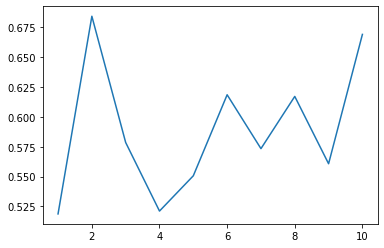

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import time

num_labels = 2
vocab_size = len(vocab) + 1
model = BoWClassifier(vocab_size)
EPOCHS = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

#reset/clear out model just in case
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

if USE_CUDA:
  model = model.cuda()

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [ ]:
def get_all_metrics(dataloader):
  '''
  Prints the accuracy, recall, precision, and F1 score for the given
  dataloader. Returns: None.
  '''
    model.eval()
    correct = 0
    total = 0
    target_true = 0
    predicted_true = 0
    correct_true = 0
    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            if USE_CUDA:
                text, label = text.cuda(), label.cuda()
            outputs = model(text)
            predicted = torch.round(torch.sigmoid(outputs))
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
            predicted_classes = predicted == 1

            target_true += torch.sum(label == 1).float()
            predicted_true += torch.sum(predicted_classes).float()
            correct_true += torch.sum(
                (predicted_classes == label) * (predicted_classes == 1)).float()


    recall = correct_true / target_true
    precision = correct_true / predicted_true
    f1_score = 2 * precision * recall / (precision + recall)

    print("Total: {}, correct: {}".format(total, correct))
    print("Accuracy: {}".format(correct/total))
    print("Recall: {}".format(recall))
    print("Precision: {}".format(precision))
    print("F1 score: {}".format(f1_score))

In [ ]:
get_all_metrics(test_dataloader)

Total: 7311, correct: 4149
Accuracy: 0.5675010258514567
Recall: 0.6210153698921204
Precision: 0.1562221497297287
F1 score: 0.24964404106140137


### Continuous Bag of Words

In [ ]:
#create dataloaders
train_dataloader = DataLoader(inspections_train, batch_size=BATCH_SIZE, shuffle=True, 
                                collate_fn=collate_into_cbow)
valid_dataloader = DataLoader(inspections_val, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_cbow)
test_dataloader = DataLoader(inspections_test, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_cbow)

In [ ]:
from torch import nn
import torch.nn.functional as F

class CBoWClassifier(nn.Module):

    def __init__(self, vocab_size):
        super(CBoWClassifier, self).__init__()
        self.linear1 = nn.Linear(vocab_size, 16)
        self.linear2 = nn.Linear(16, 1)
        self.hidden1 = nn.Tanh()
    
    def forward(self, bow_vec):
        x = self.hidden1(self.linear1(bow_vec))
        x = self.linear2(x)
        return x


At iteration 200 the loss is 0.688.
At iteration 400 the loss is 0.687.
At iteration 600 the loss is 0.683.
Total: 5849, correct: 2237

After epoch 1 the validation accuracy is 0.382.

At iteration 200 the loss is 0.679.
At iteration 400 the loss is 0.692.
At iteration 600 the loss is 0.676.
Total: 5849, correct: 2831

After epoch 2 the validation accuracy is 0.484.

At iteration 200 the loss is 0.676.
At iteration 400 the loss is 0.682.
At iteration 600 the loss is 0.689.
Total: 5849, correct: 3164

After epoch 3 the validation accuracy is 0.541.

At iteration 200 the loss is 0.646.
At iteration 400 the loss is 0.688.
At iteration 600 the loss is 0.653.
Total: 5849, correct: 3333

After epoch 4 the validation accuracy is 0.570.

At iteration 200 the loss is 0.667.
At iteration 400 the loss is 0.644.
At iteration 600 the loss is 0.661.
Total: 5849, correct: 3323

After epoch 5 the validation accuracy is 0.568.

At iteration 200 the loss is 0.649.
At iteration 400 the loss is 0.620.
At 

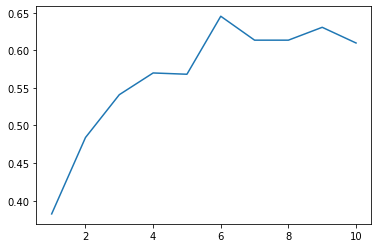

In [ ]:
num_labels = 2
vocab_size = 300
model = CBoWClassifier(vocab_size)
EPOCHS = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

#reset/clear out model just in case
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

if USE_CUDA:
  model = model.cuda()

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [ ]:
get_all_metrics(test_dataloader)

Total: 7311, correct: 2719
Accuracy: 0.37190534810559434
Recall: 0.8276269435882568
Precision: 0.1361958384513855
F1 score: 0.23390056192874908


### Ngrams

In [ ]:
#create dataloaders
train_dataloader = DataLoader(inspections_train, batch_size=BATCH_SIZE, shuffle=True, 
                                collate_fn=collate_into_ngrams)
valid_dataloader = DataLoader(inspections_val, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_ngrams)
test_dataloader = DataLoader(inspections_test, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_ngrams)

In [ ]:
from torch import nn
import torch.nn.functional as F

class NGramClassifier(nn.Module):

    def __init__(self, vocab_size):
        super(NGramClassifier, self).__init__()
        self.linear1 = nn.Linear(vocab_size, 16)
        self.linear2 = nn.Linear(16, 1)
        self.hidden1 = nn.Tanh()
    
    def forward(self, bow_vec):
        x = self.hidden1(self.linear1(bow_vec))
        x = self.linear2(x)
        return x


At iteration 200 the loss is 0.693.
At iteration 400 the loss is 0.694.
At iteration 600 the loss is 0.689.
Total: 5849, correct: 730

After epoch 1 the validation accuracy is 0.125.

At iteration 200 the loss is 0.692.
At iteration 400 the loss is 0.686.
At iteration 600 the loss is 0.689.
Total: 5849, correct: 845

After epoch 2 the validation accuracy is 0.144.

At iteration 200 the loss is 0.682.
At iteration 400 the loss is 0.679.
At iteration 600 the loss is 0.685.
Total: 5849, correct: 1924

After epoch 3 the validation accuracy is 0.329.

At iteration 200 the loss is 0.690.
At iteration 400 the loss is 0.678.
At iteration 600 the loss is 0.666.
Total: 5849, correct: 2792

After epoch 4 the validation accuracy is 0.477.

At iteration 200 the loss is 0.679.
At iteration 400 the loss is 0.665.
At iteration 600 the loss is 0.681.
Total: 5849, correct: 3558

After epoch 5 the validation accuracy is 0.608.

At iteration 200 the loss is 0.663.
At iteration 400 the loss is 0.660.
At it

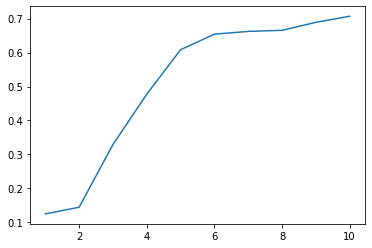

In [ ]:
vocab_size = vocab_ngrams.shape[1]
model = NGramClassifier(vocab_size)
EPOCHS = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

#reset/clear out model just in case
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

if USE_CUDA:
  model = model.cuda()

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [ ]:
get_all_metrics(test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Total: 7311, correct: 4200
Accuracy: 0.5744768157570784
Recall: 0.5489964485168457
Precision: 0.14558547735214233
F1 score: 0.2301410585641861


### Using weights instead of oversampling

In [ ]:
#Split data but don't oversample
train_x, val_x, train_y, val_y = train_test_split(train_feat_txt, train_targ,
                                                    test_size=0.2, shuffle=False)

In [ ]:
#and convert to dataset object
inspections_train = InspectionsDataset(train_x, train_y)
inspections_val = InspectionsDataset(val_x, val_y)
inspections_test = InspectionsDataset(test_feat_txt, test_targ)


In [ ]:
BATCH_SIZE = 64
#create dataloaders
train_dataloader = DataLoader(inspections_train, batch_size=BATCH_SIZE, shuffle=True, 
                                collate_fn=collate_into_bow)
valid_dataloader = DataLoader(inspections_val, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_bow)
test_dataloader = DataLoader(inspections_test, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_bow)

In [ ]:
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):

    def __init__(self, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear1 = nn.Linear(vocab_size, 16)
        self.linear2 = nn.Linear(16, 1)
        self.hidden1 = nn.Tanh()
    
    def forward(self, bow_vec):
        x = self.hidden1(self.linear1(bow_vec))
        x = self.linear2(x)
        return x


In [ ]:
weights = torch.tensor([875, 125])
weights = weights / weights.sum()
weights = 1/weights
print(weights)

tensor([1.1429, 8.0000])


In [ ]:
weights = weights[1].to(DEVICE)
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=weights)

At iteration 100 the loss is 1.264.
At iteration 200 the loss is 0.913.
At iteration 300 the loss is 1.288.
Total: 5953, correct: 5402

After epoch 1 the validation accuracy is 0.907.

At iteration 100 the loss is 0.919.
At iteration 200 the loss is 0.822.
At iteration 300 the loss is 1.422.
Total: 5953, correct: 5402

After epoch 2 the validation accuracy is 0.907.

At iteration 100 the loss is 1.056.
At iteration 200 the loss is 1.197.
At iteration 300 the loss is 0.947.
Total: 5953, correct: 5305

After epoch 3 the validation accuracy is 0.891.



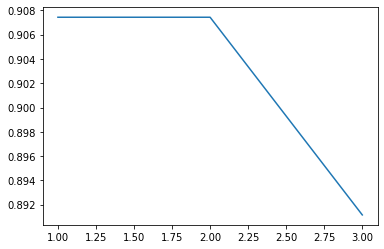

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import time

num_labels = 2
vocab_size = len(vocab) + 1
model = BoWClassifier(vocab_size)
EPOCHS = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

#reset/clear out model just in case
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

if USE_CUDA:
  model = model.cuda()

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [ ]:
get_all_metrics(test_dataloader)

Total: 7442, correct: 6328
Accuracy: 0.8503090567051867
Recall: 0.13931523263454437
Precision: 0.23459245264530182
F1 score: 0.17481482028961182
